# train

In [1]:
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp

import utils
import metrics
import time
import plot
from svgd import SVGD

rkey = random.PRNGKey(10)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
dist = metrics.Gaussian(0, 1)
dist = metrics.GaussianMixture([-2, 2], [1, 1], [1/3, 2/3])

n_steps = 1000
svgd = SVGD(dist, n_steps)

In [3]:
n = 100
h = 1
lr = 1
svgd_stepsize = 0.01
bandwidth = h
ksd_bandwidth = 1

In [4]:
rkey = random.split(rkey)[0]

### train

In [5]:
st = time.time()
x_grad, x_svgd, log_grad, log_svgd, losses = svgd.train(rkey, h, lr, svgd_stepsize, n_steps, n, ksd_bandwidth)
x_grad.block_until_ready()
end = time.time()
print(f"took {end - st} seconds")

took 30.467724800109863 seconds


In [6]:
st = time.time()
x0 = svgd.initialize(rkey, n)
xs, logs = svgd.svgd(x0, svgd_stepsize, h, n_steps)
end = time.time()
print(f"took {end - st} seconds")

JIT COMPILING svgd...
...done compiling svgd after 0.6543986797332764 seconds.
took 5.013498544692993 seconds


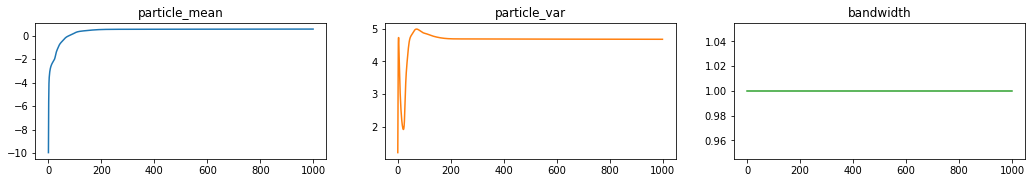

In [7]:
plot.svgd_log(log_svgd)

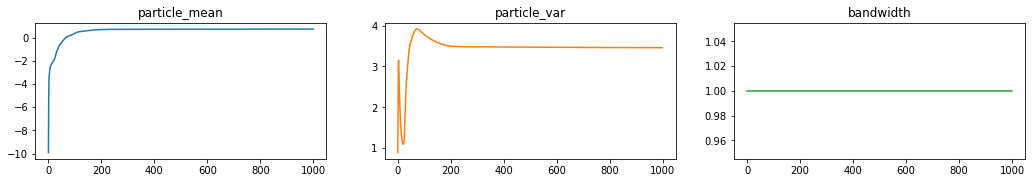

In [8]:
plot.svgd_log(log_grad)

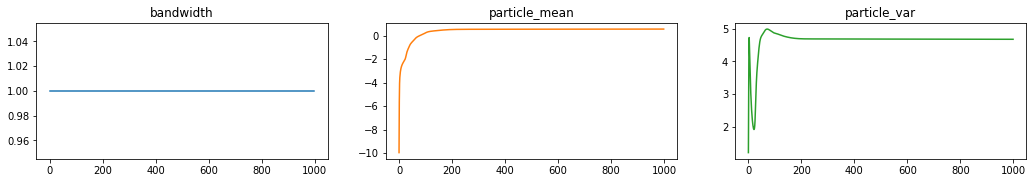

In [9]:
plot.svgd_log(logs)

## Histograms

### Learned bandwidth

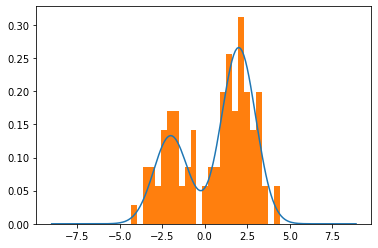

In [10]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(x_svgd[:, 0], density=True, bins=25)

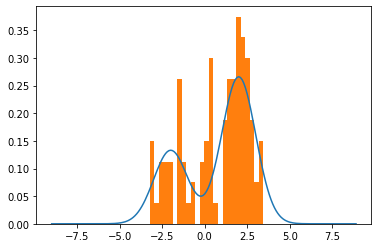

In [11]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(x_grad[:, 0], density=True, bins=25)

## Fixed bandwidth

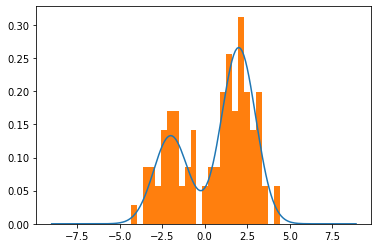

In [12]:
grid = np.arange(-9, 9, 0.1)

_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(xs[:, 0], density=True, bins=25)

# compare sample

In [13]:
s = dist.sample(shape=(n,))

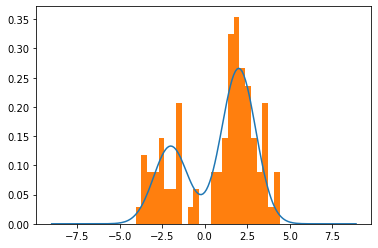

In [14]:
_ = plt.plot(grid, vmap(dist.pdf)(grid))
_ = plt.hist(s, density=True, bins=25)

In [15]:
s = s[:, np.newaxis]

In [16]:
dist.compute_metrics(s)

{'square_errors': DeviceArray([[0.03803014],
              [0.95213264],
              [0.0164856 ],
              [0.00256213]], dtype=float32),
 'ksds': DeviceArray([93.037674 ,  2.4144995,  0.4228699], dtype=float32)}

In [17]:
dist.compute_metrics(x_grad)

{'square_errors': DeviceArray([[0.00376698],
              [1.0162609 ],
              [0.00786848],
              [0.00533669]], dtype=float32),
 'ksds': DeviceArray([119.24955   ,   2.562825  ,   0.88944215], dtype=float32)}

In [18]:
dist.compute_metrics(x_svgd)

{'square_errors': DeviceArray([[1.07743163e-02],
              [1.73049957e-05],
              [1.03948505e-05],
              [8.64357746e-04]], dtype=float32),
 'ksds': DeviceArray([8.4274582e+01, 1.0183631e-03, 1.0068595e-04], dtype=float32)}

In [19]:
dist.compute_metrics(xs)

{'square_errors': DeviceArray([[1.0774415e-02],
              [1.7392385e-05],
              [1.0395619e-05],
              [8.6433406e-04]], dtype=float32),
 'ksds': DeviceArray([8.4269386e+01, 1.0191507e-03, 1.0083973e-04], dtype=float32)}